<a href="https://colab.research.google.com/github/AmiraBelkis/Neural-Network-Reduction-via-Knowledge-Transfer/blob/main/CIFAR-100/AG_GoogLeNet_Cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rssrc

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Aug 12 10:29:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Importer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Bibliothèques

In [ ]:
import random
import string
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import matplotlib.colors as colors
import numpy as np
from copy import deepcopy

In [ ]:
import AG

100%|██████████| 169001437/169001437 [00:02<00:00, 68039304.04it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import importlib
import global_param
importlib.reload(global_param)
importlib.reload(AG)

Files already downloaded and verified
Files already downloaded and verified


<module 'AG' from '/content/AG.py'>

# AG

In [ ]:
model_path = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Models/Cifar-100/googlenet_cifar_100'
model_base = torch.load(model_path)

In [ ]:
AG.evaluation_2(model_base , nn.CrossEntropyLoss())

Accuracy: 46.00%
Loss: 3.1411


(0.46, 3.1411498944470835)

##  Affiner le modèle de base

### Augmentation de données

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import  CIFAR100

def load_cifar_100():
    # Define the data transformations
    data_transforms = {
        # use transforms.Compose to perform multiples transfomation at once
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=32, padding=4),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
        ]),
        'val': transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
        ]),
    }

    # Download and load the MNIST dataset
    train_dataset = CIFAR100(root='./data', train=True, transform=data_transforms['train'],download=True)
    test_dataset = CIFAR100(root='./data',  train=False, transform=data_transforms['val'],download=True)
    image_datasets ={
        'train':train_dataset,
        'val':test_dataset
    }
    # Create data loaders
    batch_size = 64
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
                        for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    return [dataloaders,dataset_sizes,class_names,device]


dataloaders,dataset_sizes,class_names,device = load_cifar_100()

Files already downloaded and verified
Files already downloaded and verified


### Entraînement

In [ ]:
def train_model(model, criterion, optimizer, scheduler , num_epochs=7):
    since = time.time()
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    statics = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            statics.append(
                {'epoch': epoch+1, 'phase': phase, 'acc': epoch_acc, 'loss': epoch_loss}
            )
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, statics

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv  =  optim.SGD(model_base.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)
model , statics = train_model(model_base, criterion , optimizer_conv , exp_lr_scheduler , 5)

Epoch 0/4
----------
train Loss: 1.6916 Acc: 0.5421
val Loss: 1.1702 Acc: 0.6587

Epoch 1/4
----------
train Loss: 1.1935 Acc: 0.6561
val Loss: 0.9412 Acc: 0.7228

Epoch 2/4
----------
train Loss: 1.0209 Acc: 0.6993
val Loss: 0.8888 Acc: 0.7380

Epoch 3/4
----------
train Loss: 0.9105 Acc: 0.7298
val Loss: 0.8564 Acc: 0.7503

Epoch 4/4
----------
train Loss: 0.8302 Acc: 0.7513
val Loss: 0.8367 Acc: 0.7527

Training complete in 26m 18s
Best val Acc: 0.752700


In [ ]:
torch.save(model,model_path)

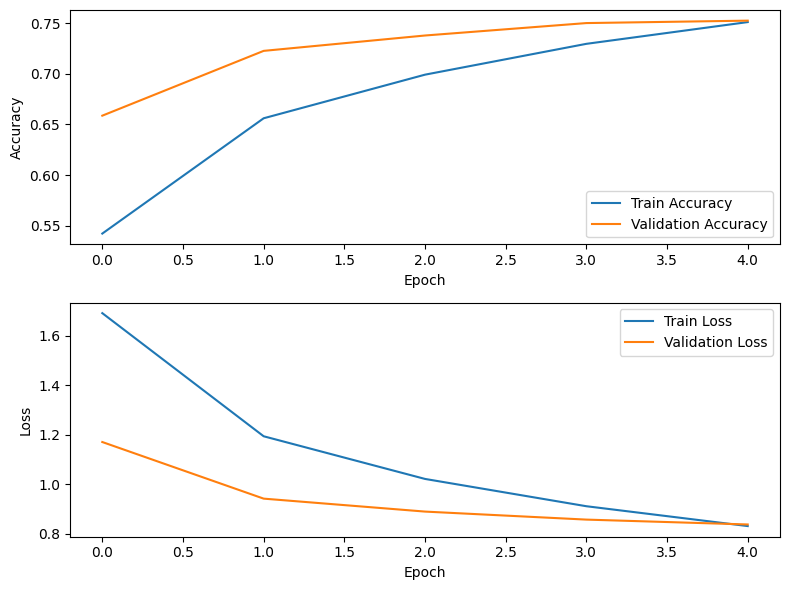

In [ ]:
AG.show_statics_training(statics, model_path + 'fine-tune (data augmentation) ' )

In [ ]:
AG.evaluation_2(model_base , nn.CrossEntropyLoss())

Accuracy: 75.27%
Loss: 0.8383


(0.7527, 0.8383286342879009)

## Méthode AG

In [ ]:
save_to = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Cifar-100/GoogLeNet/'
os.makedirs(save_to, exist_ok=True)
os.makedirs(save_to +'children/', exist_ok=True)
os.makedirs(save_to +'parents/', exist_ok=True)
os.makedirs(save_to +'kd/', exist_ok=True)
os.makedirs(save_to +'kd/training/', exist_ok=True)

Generating the initial population :
     - individual 0 ----------- 100%
     - individual 1 ----------- 100%
     - individual 2 ----------- 100%
     - individual 3 ----------- 100%
     - individual 4 ----------- 100%
     - individual 5 ----------- 100%
     - individual 6 ----------- 100%
     - individual 7 ----------- 100%
Performing KD on the initial population :
------------------------------ Training 1 ---------------------------------
Epoch 0/4
----------
train Loss: 1.9587 Acc: 0.0271
val Loss: 1.8107 Acc: 0.0381

Epoch 1/4
----------
train Loss: 1.7818 Acc: 0.0456
val Loss: 1.7374 Acc: 0.0569

Epoch 2/4
----------
train Loss: 1.7079 Acc: 0.0694
val Loss: 1.6616 Acc: 0.0854

Epoch 3/4
----------
train Loss: 1.6549 Acc: 0.0832
val Loss: 1.5841 Acc: 0.1089

Epoch 4/4
----------
train Loss: 1.6054 Acc: 0.0981
val Loss: 1.5609 Acc: 0.1243

Training complete in 27m 53s
Best val Acc: 0.124300
------------------------------ Training 2 ---------------------------------
Epoch 0/4
--

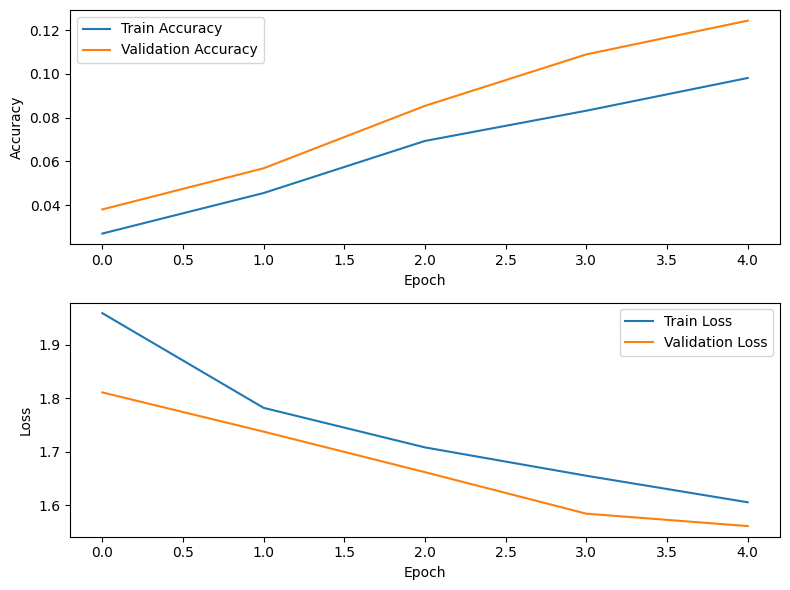

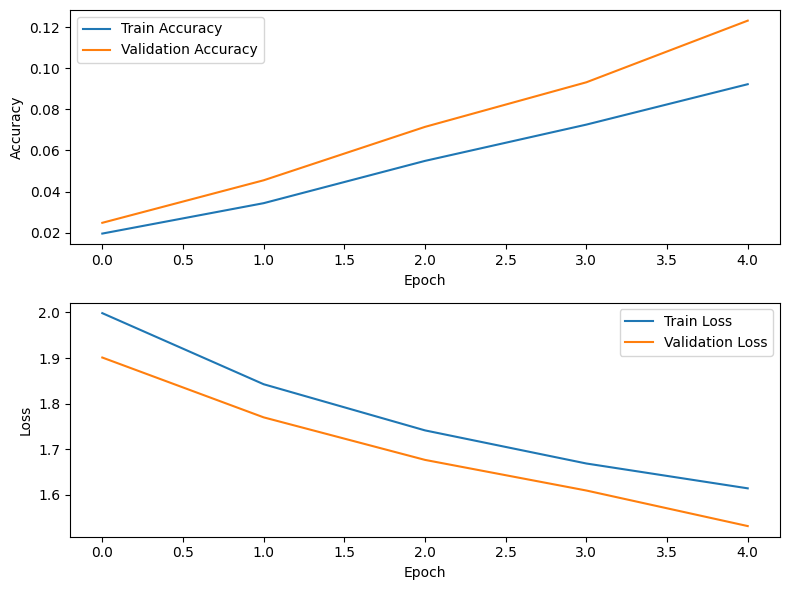

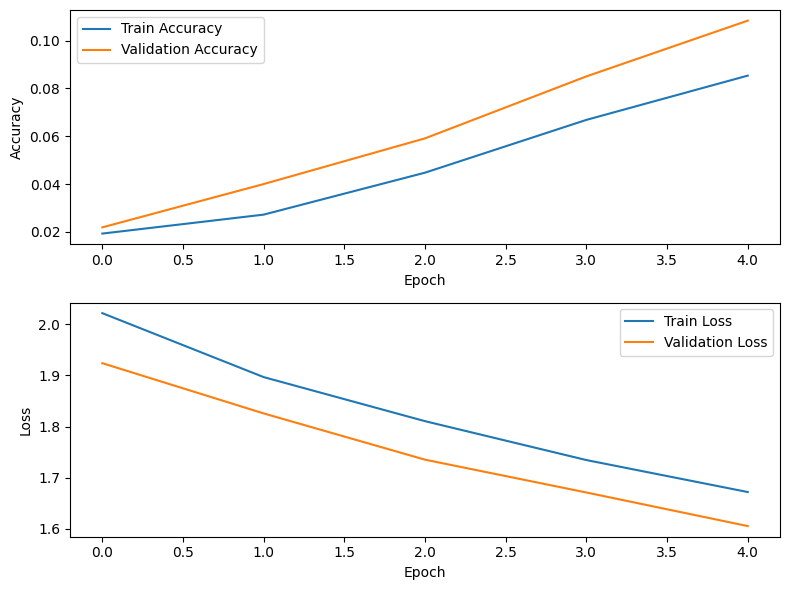

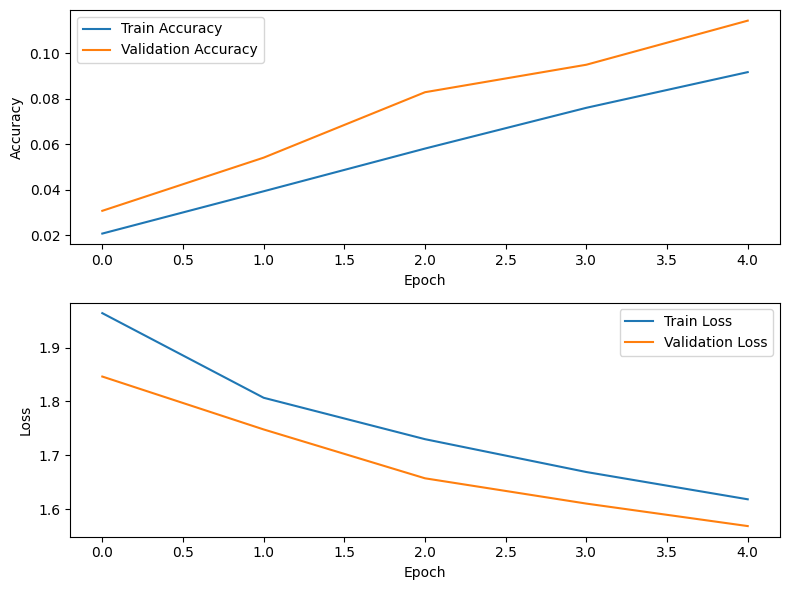

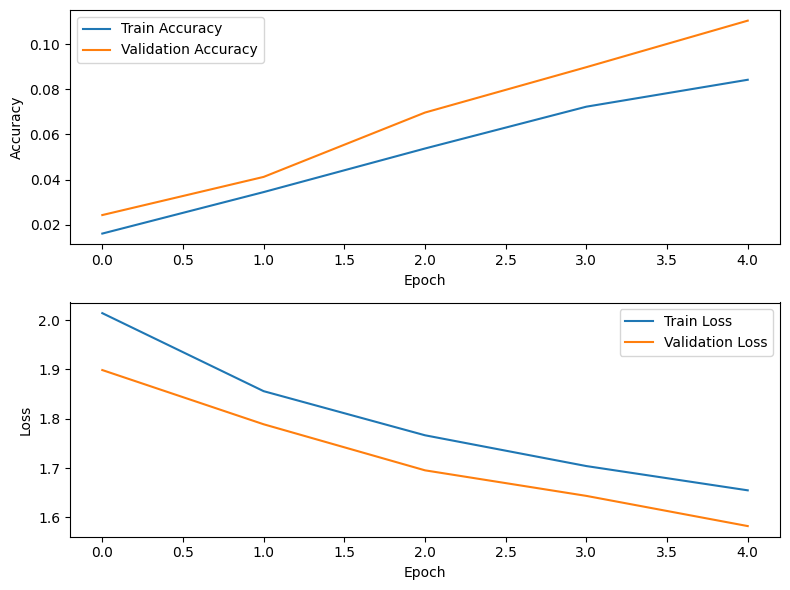

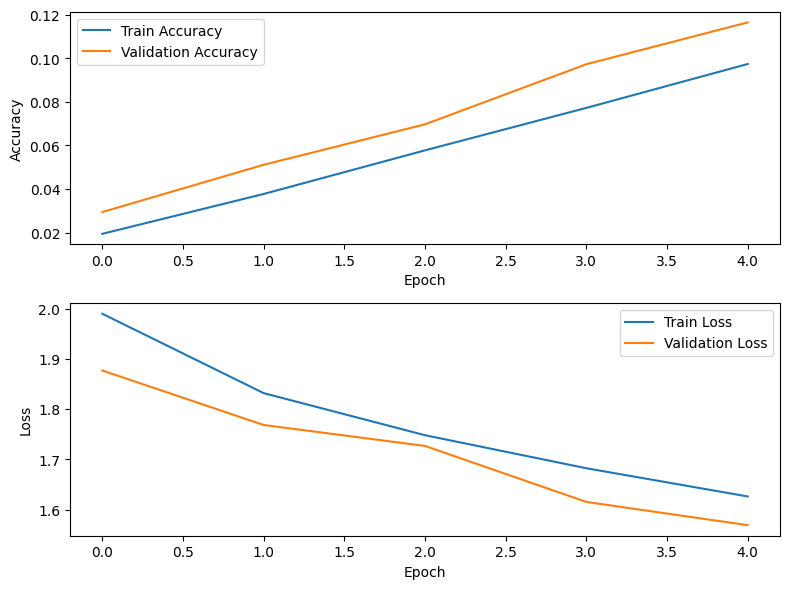

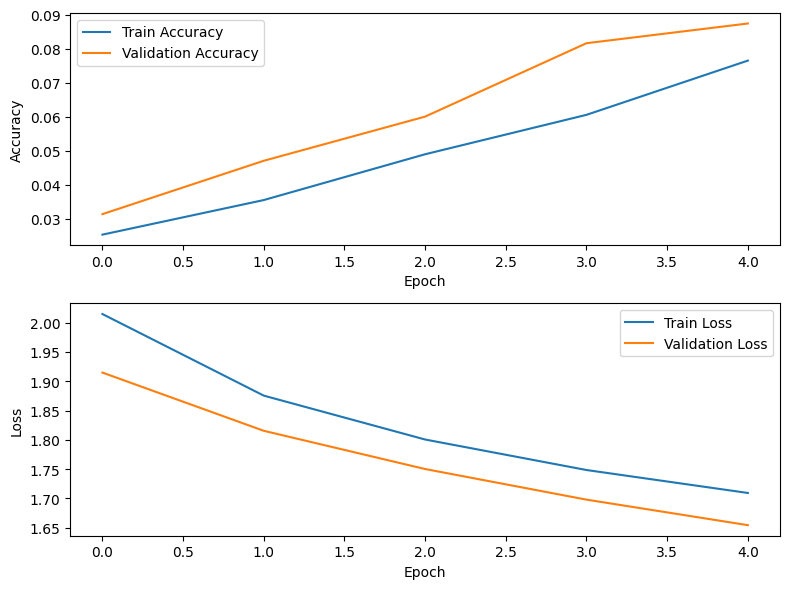

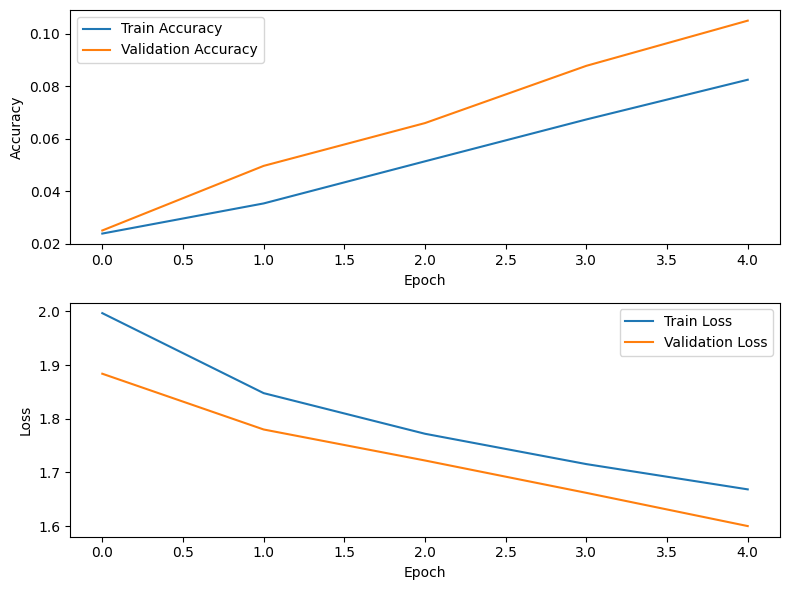

/*-----------------------------*/
/*         iteration 1        */
/*----------------------------*/
   * Select parent for crossing:
       - Selection --------------- 100%
   * Offspring:
       - Crossover:
           mask : [1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]
       - mutation:
       - Crossover:
           mask : [0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]
       - Performing KD o

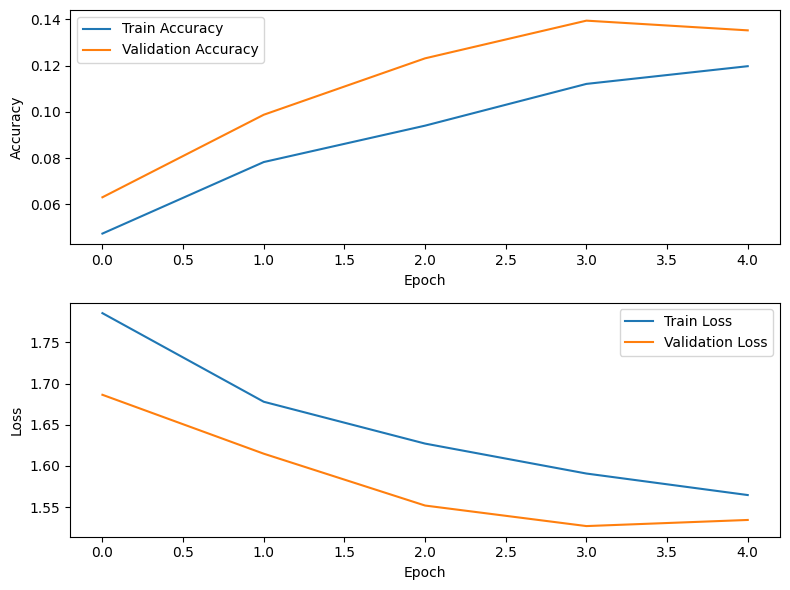

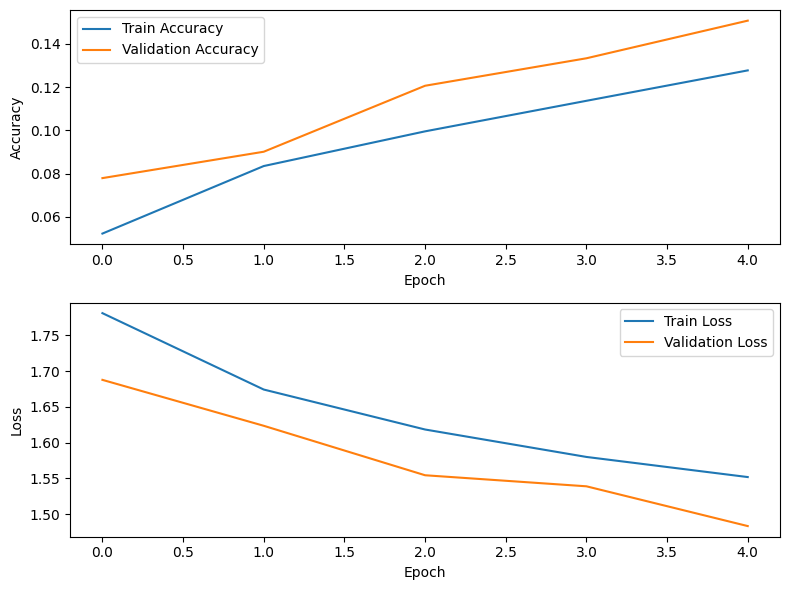

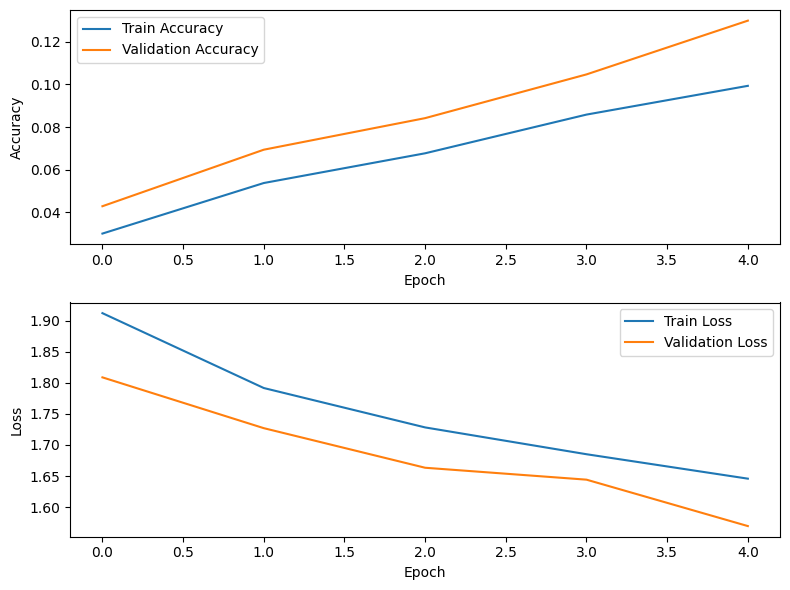

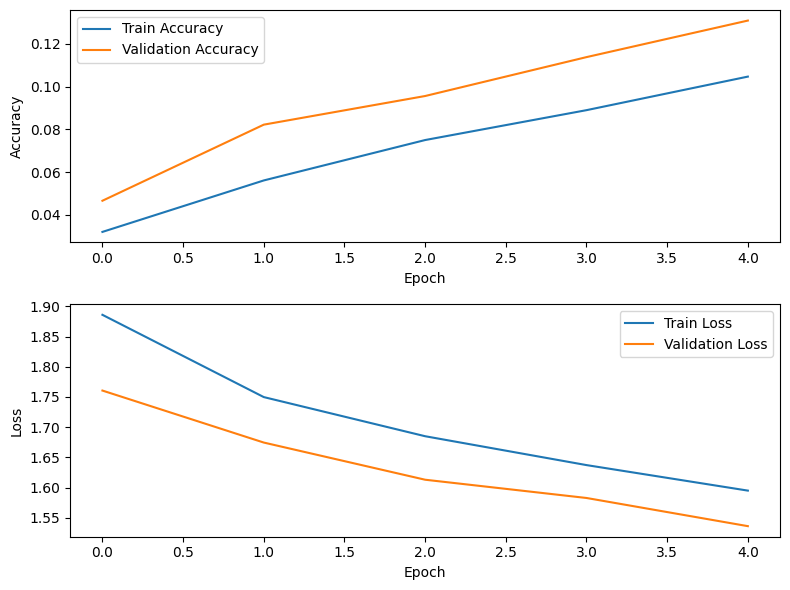

/*-----------------------------*/
/*         iteration 2        */
/*----------------------------*/
   * Select parent for crossing:
       - Selection --------------- 100%
   * Offspring:
       - Crossover:
           mask : [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1]
       - Crossover:
           mask : [0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1]
       - Performing KD on the children :
--

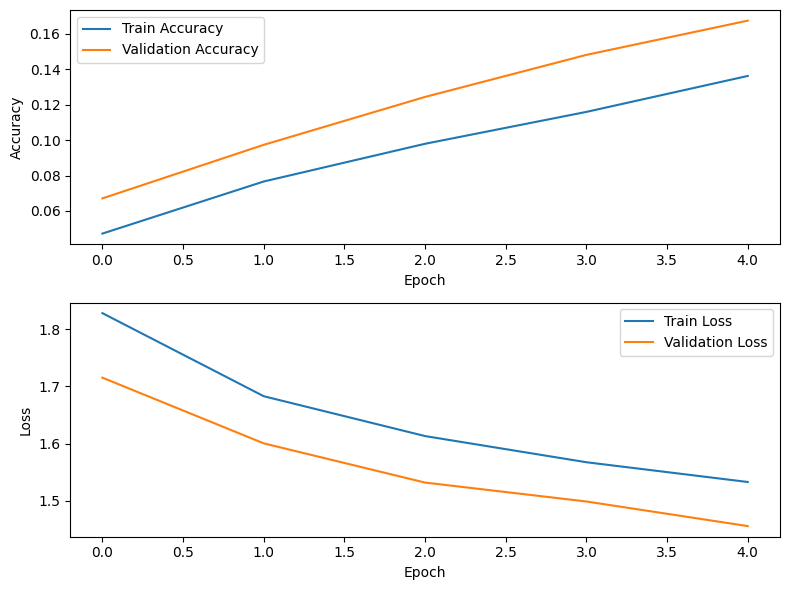

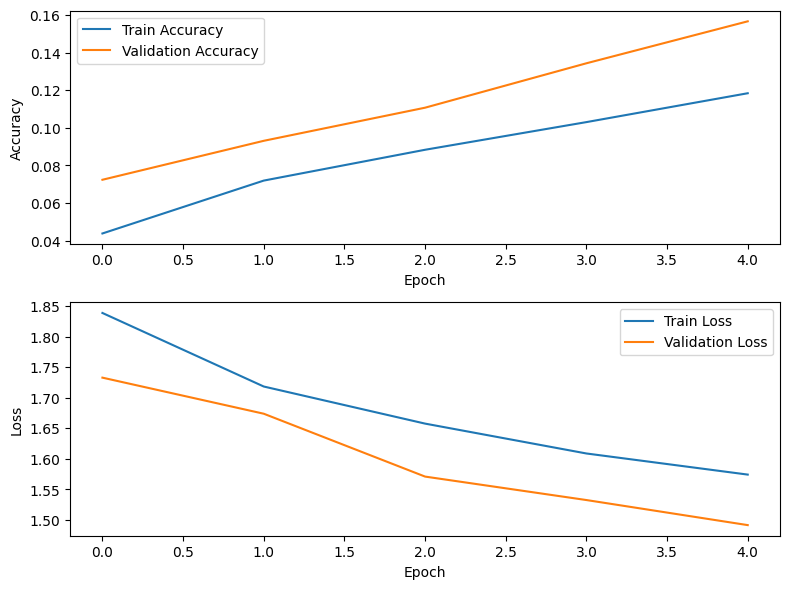

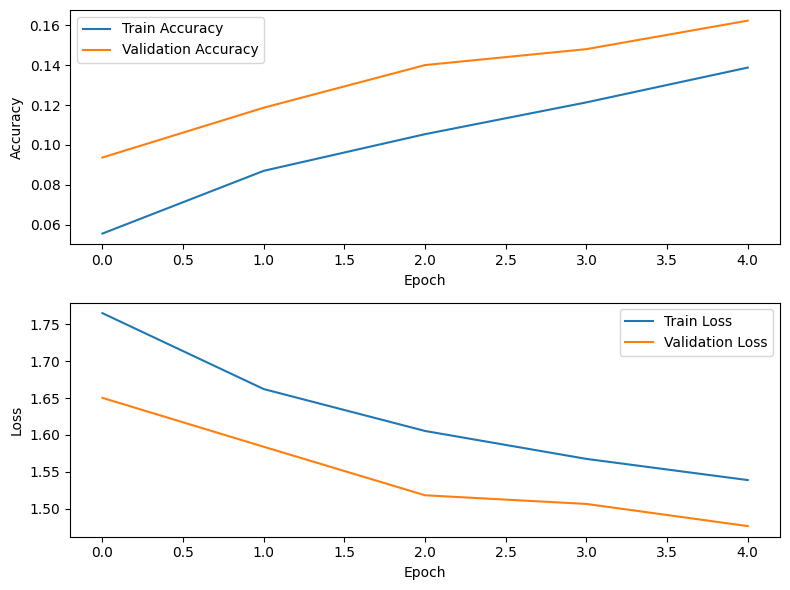

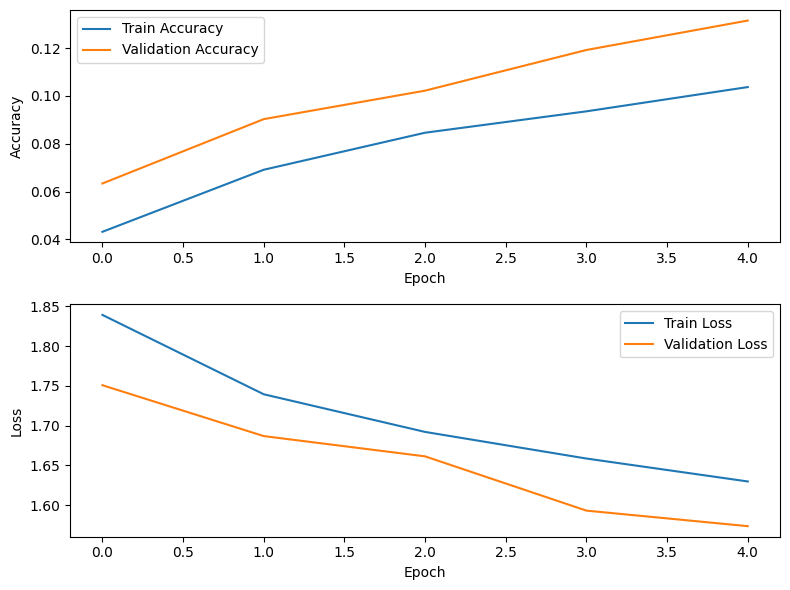

Select the winning ticket from final population
  - Selection --------------- 100%


In [ ]:
winning_ticket = AG.AG_method(model_base, save_to, nb_itr = 2, N = 8 ,pruning_rate = 0.85, pruning_space = 0.05,kd_epoch = 5)

##  Évaluer le ticket gagnant

In [ ]:
winning_ticket = torch.load( save_to + 'winning_ticket')

In [ ]:
AG.calculate_sparsity(winning_ticket)

tensor(0.8553, device='cuda:0')

In [ ]:
AG.evaluation_2(winning_ticket, nn.CrossEntropyLoss())

Accuracy: 15.66%
Loss: 3.4614


(0.1566, 3.4613783708803214)

In [ ]:
data = AG.dataloaders['val']
for in_ , lbl in data:
  in_ = in_.to(AG.device)
  lbl = lbl.to(AG.device)
  out = winning_ticket(in_)
  _, preds = torch.max(out, 1)
  print(preds)
  print('-'*10)
  print(lbl)
  print('-'*10)
  print(preds-lbl)
  break

tensor([12, 90, 60, 45, 41, 74, 45, 74, 73, 46, 33, 49, 41, 84, 81, 55, 74, 72,
        40, 84, 28, 84, 73, 38, 82, 60, 13, 83, 41, 57, 42, 72, 42, 69, 42, 33,
        54, 71, 98, 96,  4, 72, 94, 42, 50, 26, 63, 96, 42, 46, 12, 45, 83, 88,
        40, 46, 84,  9, 83, 74, 62, 45, 92, 33], device='cuda:0')
----------
tensor([13, 68, 60, 51, 10, 79, 61,  3, 67, 29, 79, 32, 41, 13, 68, 29, 24, 90,
        46, 84, 35, 98, 95, 38, 82, 33, 13,  0, 41, 53, 43, 34, 74, 79, 65, 29,
        61, 60, 35, 38, 44, 32, 57, 63, 15, 22, 63, 60, 19, 28,  8, 11, 83, 85,
        99, 65, 26, 61, 45, 55, 92, 32, 57, 68], device='cuda:0')
----------
tensor([ -1,  22,   0,  -6,  31,  -5, -16,  71,   6,  17, -46,  17,   0,  71,
         13,  26,  50, -18,  -6,   0,  -7, -14, -22,   0,   0,  27,   0,  83,
          0,   4,  -1,  38, -32, -10, -23,   4,  -7,  11,  63,  58, -40,  40,
         37, -21,  35,   4,   0,  36,  23,  18,   4,  34,   0,   3, -59, -19,
         58, -52,  38,  19, -30,  13,  35, -35], devic

## Affiner le ticket gagnant

In [ ]:
save_to = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Cifar-100/GoogLeNet/'
winning_ticket = torch.load( save_to + 'winning_ticket')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv  =  optim.SGD(winning_ticket.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)
winning_ticket , statics = train_model(winning_ticket, criterion , optimizer_conv , exp_lr_scheduler , 10)

Epoch 0/9
----------
train Loss: 3.9021 Acc: 0.0964
val Loss: 3.5356 Acc: 0.1438

Epoch 1/9
----------
train Loss: 3.7285 Acc: 0.1207
val Loss: 3.4996 Acc: 0.1551

Epoch 2/9
----------
train Loss: 3.6441 Acc: 0.1351
val Loss: 3.2641 Acc: 0.2004

Epoch 3/9
----------
train Loss: 3.5687 Acc: 0.1496
val Loss: 3.3274 Acc: 0.1895

Epoch 4/9
----------
train Loss: 3.5160 Acc: 0.1587
val Loss: 3.1154 Acc: 0.2285

Epoch 5/9
----------
train Loss: 3.4009 Acc: 0.1762
val Loss: 2.9838 Acc: 0.2591

Epoch 6/9
----------
train Loss: 3.3766 Acc: 0.1811
val Loss: 2.9630 Acc: 0.2604

Epoch 7/9
----------
train Loss: 3.3594 Acc: 0.1852
val Loss: 2.9415 Acc: 0.2665

Epoch 8/9
----------
train Loss: 3.3439 Acc: 0.1880
val Loss: 2.9362 Acc: 0.2657

Epoch 9/9
----------
train Loss: 3.3457 Acc: 0.1879
val Loss: 2.9220 Acc: 0.2739

Training complete in 50m 7s
Best val Acc: 0.273900


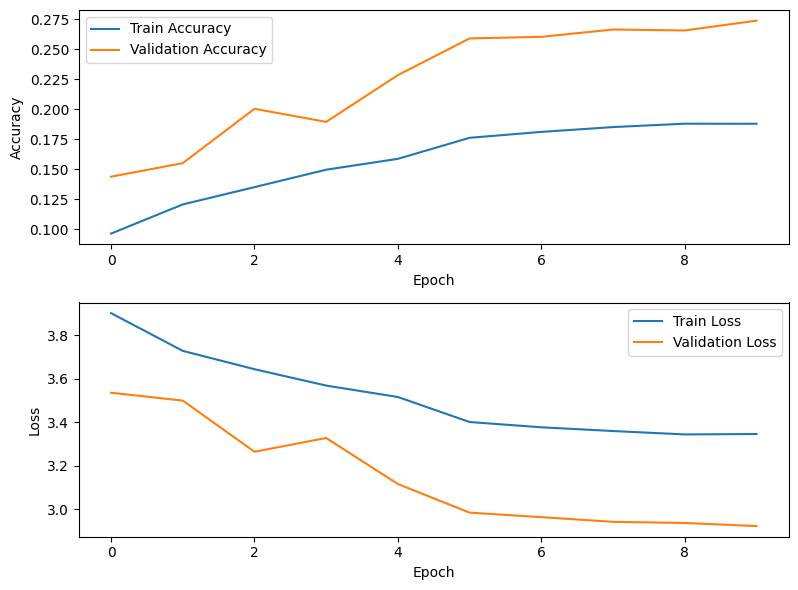

In [ ]:
AG.show_statics_training(statics, save_to + 'winning_ticket' )
torch.save(winning_ticket , save_to + 'winning_ticket')

In [ ]:
AG.evaluation_2(winning_ticket, nn.CrossEntropyLoss())

Accuracy: 27.39%
Loss: 2.9234


(0.2739, 2.9234217169937815)

## Affinage et iteration supplémentaires
Affiner le modèle de base pour effectuer itèrations supplémentaires de "AG".

### Affinage

In [ ]:
model_path = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Models/Cifar-100/googlenet_cifar_100'
model_base = torch.load(model_path)

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import  CIFAR100

def load_cifar_100():
    # Define the data transformations
    data_transforms = {
        # use transforms.Compose to perform multiples transfomation at once
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=32, padding=4),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
        ]),
        'val': transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
        ]),
    }

    # Download and load the MNIST dataset
    train_dataset = CIFAR100(root='./data', train=True, transform=data_transforms['train'],download=True)
    test_dataset = CIFAR100(root='./data',  train=False, transform=data_transforms['val'],download=True)
    image_datasets ={
        'train':train_dataset,
        'val':test_dataset
    }
    # Create data loaders
    batch_size = 64
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
                        for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    return [dataloaders,dataset_sizes,class_names,device]


dataloaders,dataset_sizes,class_names,device = load_cifar_100()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def train_model(model, criterion, optimizer, scheduler , num_epochs=7):
    since = time.time()
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    statics = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            statics.append(
                {'epoch': epoch+1, 'phase': phase, 'acc': epoch_acc, 'loss': epoch_loss}
            )
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, statics

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv  =  optim.SGD(model_base.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)
model_base , statics = train_model(model_base, criterion , optimizer_conv , exp_lr_scheduler , 8)

Epoch 0/7
----------
train Loss: 0.4664 Acc: 0.8561
val Loss: 0.6354 Acc: 0.8158

Epoch 1/7
----------
train Loss: 0.4296 Acc: 0.8675
val Loss: 0.6275 Acc: 0.8176

Epoch 2/7
----------
train Loss: 0.4168 Acc: 0.8702
val Loss: 0.6343 Acc: 0.8153

Epoch 3/7
----------
train Loss: 0.4014 Acc: 0.8760
val Loss: 0.6278 Acc: 0.8191

Epoch 4/7
----------
train Loss: 0.3779 Acc: 0.8831
val Loss: 0.6242 Acc: 0.8212

Epoch 5/7
----------
train Loss: 0.3617 Acc: 0.8890
val Loss: 0.6236 Acc: 0.8199

Epoch 6/7
----------
train Loss: 0.3577 Acc: 0.8914
val Loss: 0.6222 Acc: 0.8218

Epoch 7/7
----------
train Loss: 0.3547 Acc: 0.8918
val Loss: 0.6215 Acc: 0.8233

Training complete in 41m 16s
Best val Acc: 0.823300


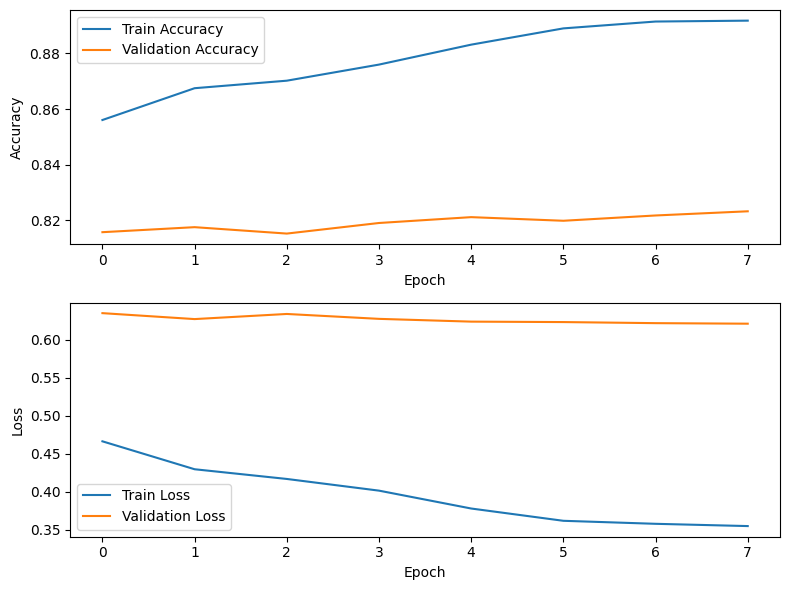

In [ ]:
AG.show_statics_training(statics, save_to + 'base model fine tuning for extra itr')
torch.save(model_base, model_path)

In [ ]:
AG.evaluation_2(model_base , nn.CrossEntropyLoss())

Accuracy: 82.33%
Loss: 0.6262


(0.8233, 0.6261691208098344)

### Itérations supplémentaires ( 3 & 4 )

In [ ]:
model_path = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Models/Cifar-100/googlenet_cifar_100'
model_base = torch.load(model_path)

In [ ]:
save_to = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Cifar-100/GoogLeNet/'
itr = 2
nb_itr = 5
kd_epoch = 8
path  = save_to + 'kd/'
files = os.listdir(path)
population = []
for file_ in files:
  if( '(itr-2)' in file_):
    indiv = torch.load(path+file_)
    population.append(indiv)
path  = save_to + 'parents/'
files = os.listdir(path)
for file_ in files:
  if( '(itr-2)' in file_):
    indiv = torch.load(path+file_)
    population.append(indiv)

In [ ]:
len(population)

8

/*-----------------------------*/
/*         iteration 3        */
/*----------------------------*/
   * Select parent for crossing:
       - Selection --------------- 100%
   * Offspring:
       - Crossover:
           mask : [0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1]
       - mutation:
       - Crossover:
           mask : [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1]
       - Performing KD o

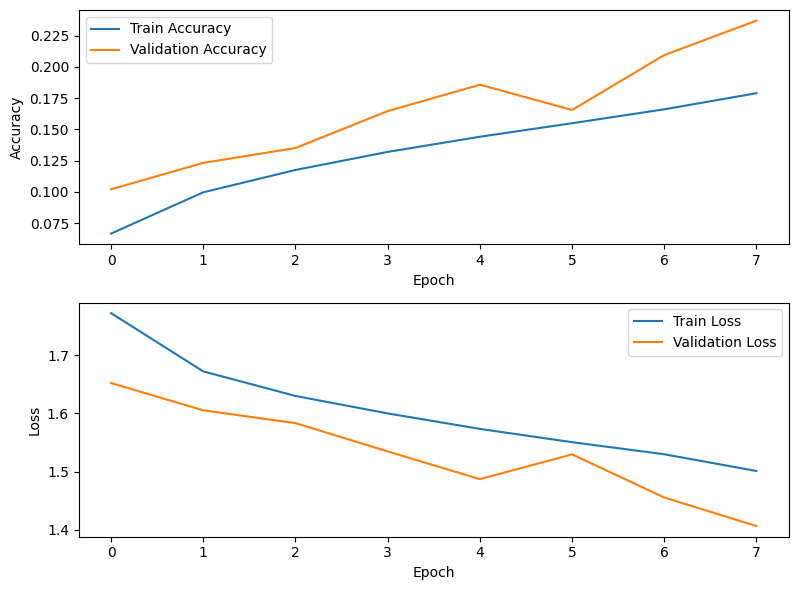

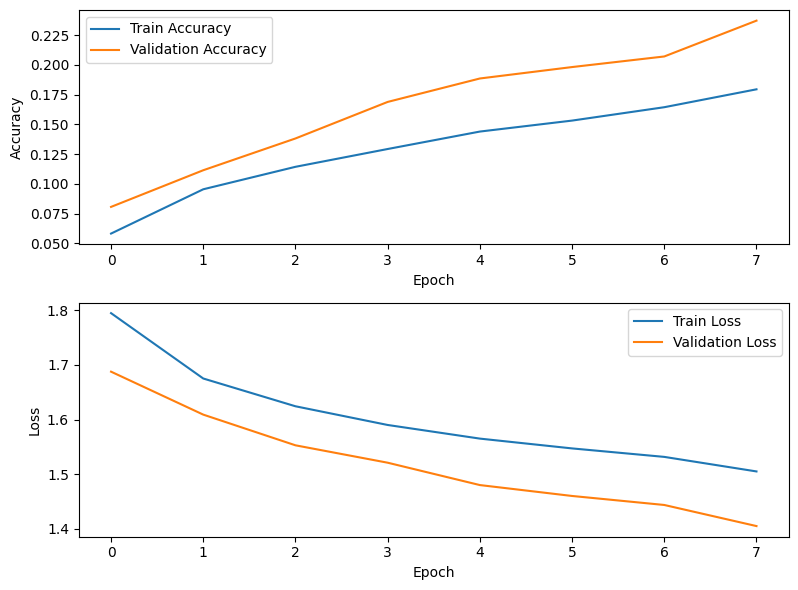

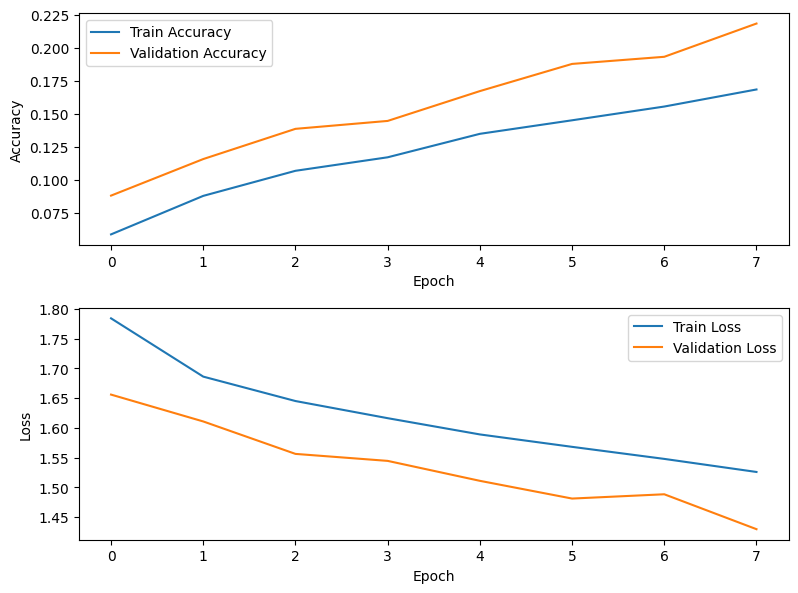

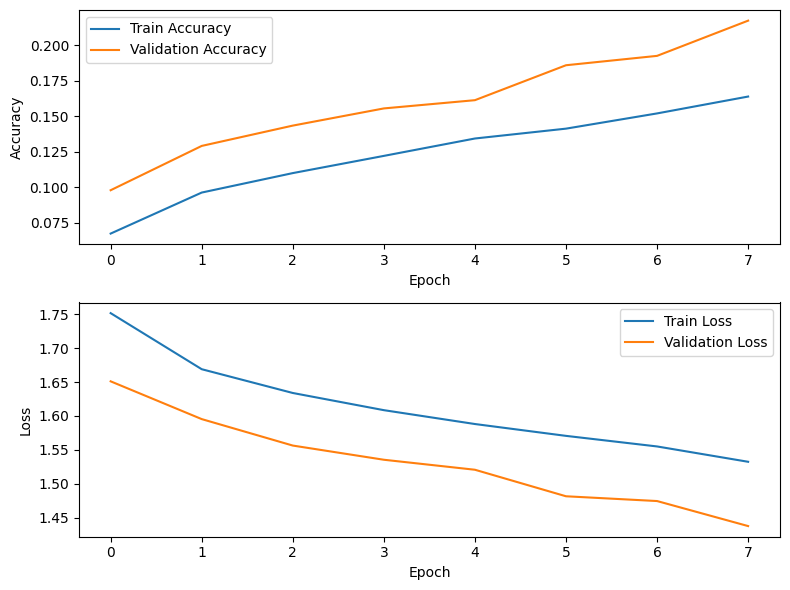

/*-----------------------------*/
/*         iteration 4        */
/*----------------------------*/
   * Select parent for crossing:
       - Selection --------------- 100%
   * Offspring:
       - Crossover:
           mask : [0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]
       - mutation:
       - Crossover:
           mask : [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
       - mutation:
     

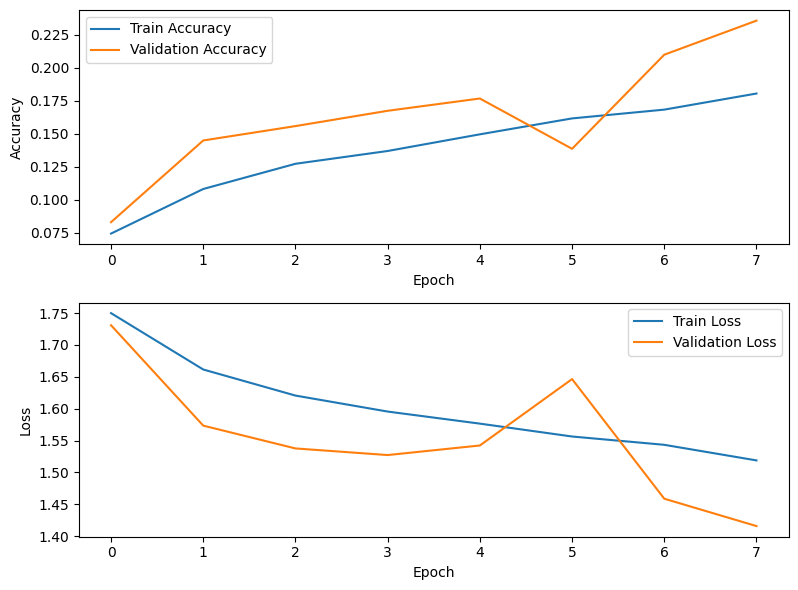

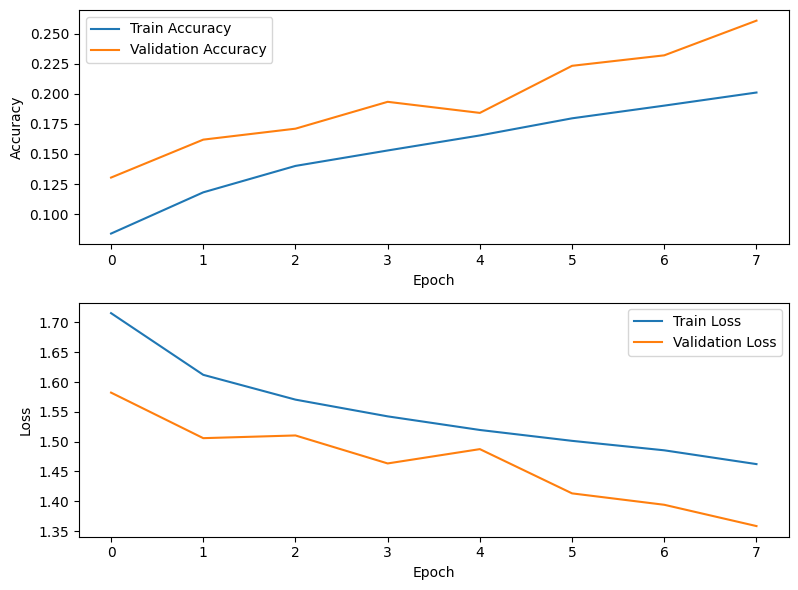

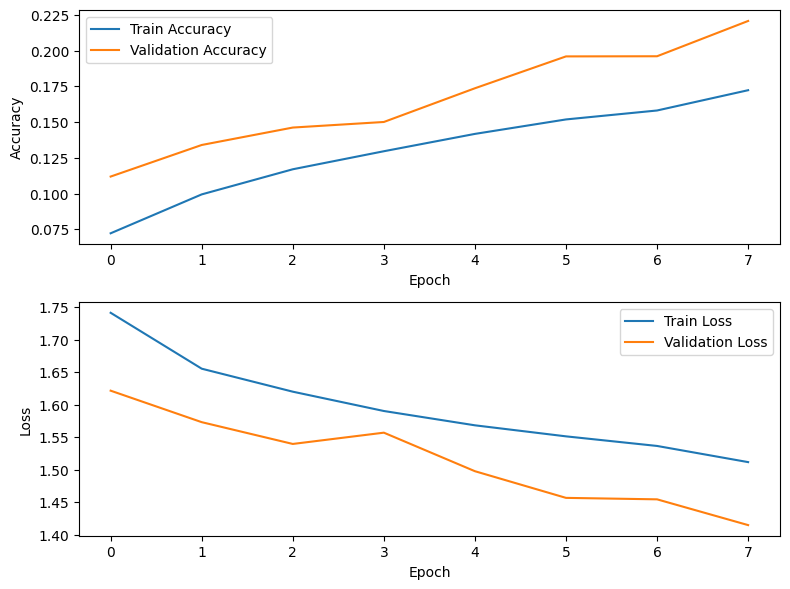

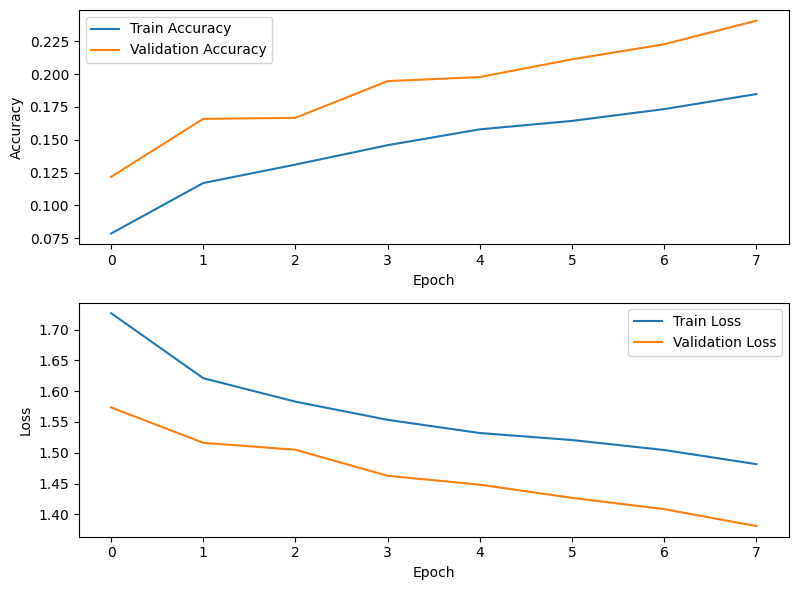

/*-----------------------------*/
/*         iteration 5        */
/*----------------------------*/
   * Select parent for crossing:
       - Selection --------------- 100%
   * Offspring:
       - Crossover:
           mask : [0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0]
       - mutation:
       - Crossover:
           mask : [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0]
       - mutation:
     

In [ ]:
winning_ticket = AG.AG_extra_itr(model_base,population, save_to, itr,nb_itr,kd_epoch)

### Itérations supplémentaires (5)

In [ ]:
model_path = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Models/Cifar-100/googlenet_cifar_100'
model_base = torch.load(model_path)

In [ ]:
save_to = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Cifar-100/GoogLeNet/'
itr = 4
nb_itr = 5
kd_epoch = 8
path  = save_to + 'kd/'
files = os.listdir(path)
population = []
for file_ in files:
  if( '(itr-4)' in file_):
    indiv = torch.load(path+file_)
    population.append(indiv)
path  = save_to + 'parents/'
files = os.listdir(path)
for file_ in files:
  if( '(itr-4)' in file_):
    indiv = torch.load(path+file_)
    population.append(indiv)

In [ ]:
len(population)

8

/*-----------------------------*/
/*         iteration 5        */
/*----------------------------*/
   * Select parent for crossing:
       - Selection --------------- 100%
   * Offspring:
       - Crossover:
           mask : [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]
       - Crossover:
           mask : [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]
       - mutation:
       - Performing KD o

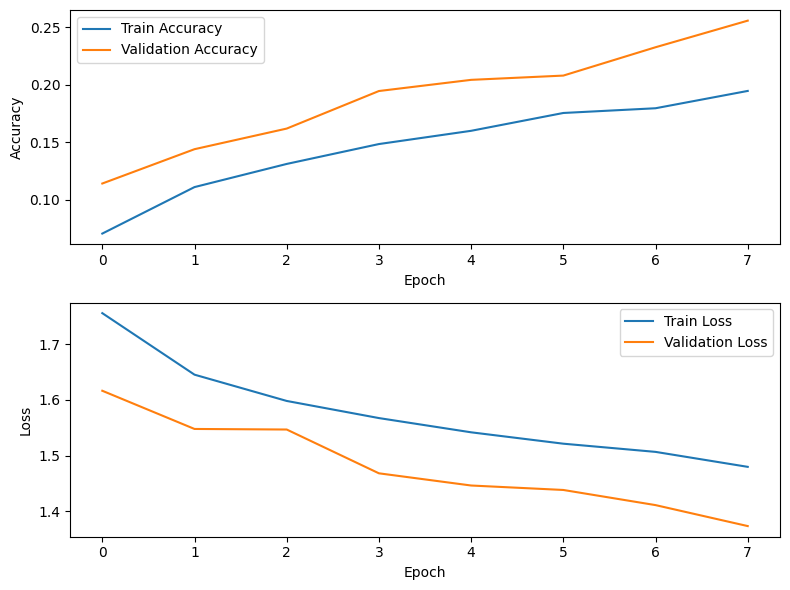

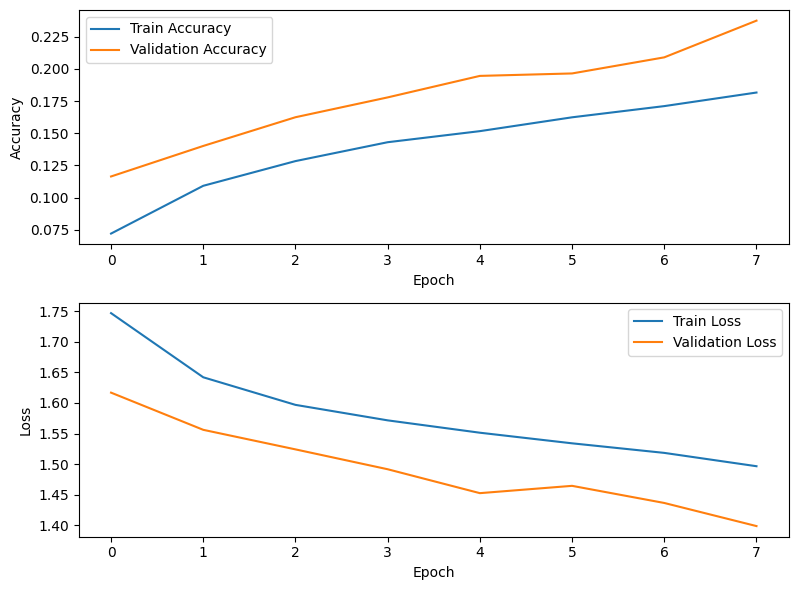

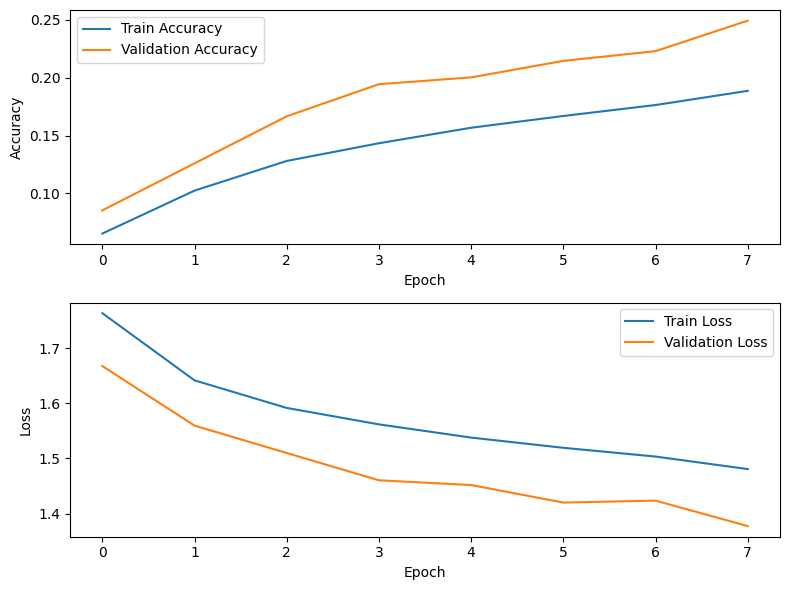

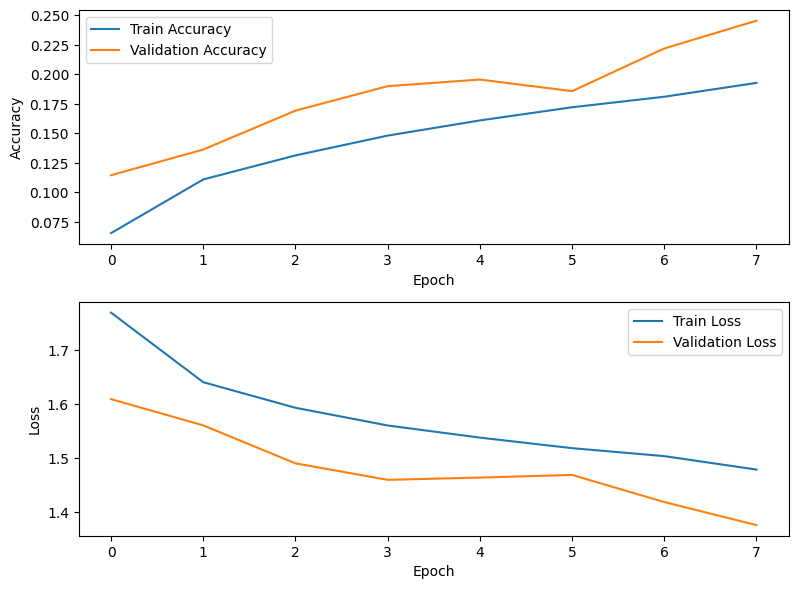

Select the winning ticket from final population
  - Selection --------------- 100%


In [ ]:
winning_ticket = AG.AG_extra_itr(model_base,population, save_to, itr,nb_itr,kd_epoch)

### Évaluer le ticket gagnant

In [ ]:
winning_ticket = torch.load( save_to + 'winning_ticket')

In [ ]:
AG.calculate_sparsity(winning_ticket)

tensor(0.8525, device='cuda:0')

In [ ]:
AG.evaluation_2(winning_ticket, nn.CrossEntropyLoss())

Accuracy: 25.56%
Loss: 2.9969


(0.2556, 2.9968881774100526)

In [ ]:
data = AG.dataloaders['val']
for in_ , lbl in data:
  in_ = in_.to(AG.device)
  lbl = lbl.to(AG.device)
  out = winning_ticket(in_)
  _, preds = torch.max(out, 1)
  print(preds)
  print('-'*10)
  print(lbl)
  print('-'*10)
  print(preds-lbl)
  break

tensor([36, 41, 87, 96, 57,  3, 11,  4, 57, 33, 73, 89, 67, 74, 59, 83, 46, 35,
        41,  4, 57, 84, 13, 55, 70, 17, 36, 24, 14, 55, 23, 13, 67, 49, 40, 53,
        61, 78, 69, 31, 22, 62, 20, 72, 81, 96,  0, 74, 95, 54, 88, 61, 94, 42,
        55, 17, 78, 64, 84, 94, 57, 17, 61,  5], device='cuda:0')
----------
tensor([36, 41, 46, 33, 57, 55, 32, 18,  0,  4, 30,  8, 16, 44, 96, 22, 35, 92,
        41, 88, 53, 66, 13, 93, 11, 37, 51, 28, 79, 84, 30, 13, 28, 76, 91, 62,
        99, 27, 69, 38,  1, 82, 20, 46, 37, 27,  0,  7, 73, 92, 34, 61, 16, 42,
        93, 76, 26, 29, 28, 94, 10, 17, 16, 16], device='cuda:0')
----------
tensor([  0,   0,  41,  63,   0, -52, -21, -14,  57,  29,  43,  81,  51,  30,
        -37,  61,  11, -57,   0, -84,   4,  18,   0, -38,  59, -20, -15,  -4,
        -65, -29,  -7,   0,  39, -27, -51,  -9, -38,  51,   0,  -7,  21, -20,
          0,  26,  44,  69,   0,  67,  22, -38,  54,   0,  78,   0, -38, -59,
         52,  35,  56,   0,  47,   0,  45, -11], devic

### Effectuer la distillation des connaissances pendant des epochs supplémentaires.

In [ ]:
model_path = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Models/Cifar-100/googlenet_cifar_100'
model_base = torch.load(model_path)

In [ ]:
save_to = '/content/drive/Shareddrives/PFE 22 23 Feliachi et Frioui/..Tests/Cifar-100/GoogLeNet/'
winning_ticket = torch.load( save_to + 'winning_ticket')

------------------------------ Training ---------------------------------
Epoch 0/34
----------
train Loss: 1.4893 Acc: 0.1919
val Loss: 1.4908 Acc: 0.2019

Epoch 1/34
----------
train Loss: 1.4802 Acc: 0.1957
val Loss: 1.4006 Acc: 0.2395

Epoch 2/34
----------
train Loss: 1.4707 Acc: 0.2040
val Loss: 1.3712 Acc: 0.2491

Epoch 3/34
----------
train Loss: 1.4604 Acc: 0.2116
val Loss: 1.3928 Acc: 0.2486

Epoch 4/34
----------
train Loss: 1.4525 Acc: 0.2173
val Loss: 1.3988 Acc: 0.2465

Epoch 5/34
----------
train Loss: 1.4461 Acc: 0.2230
val Loss: 1.3371 Acc: 0.2800

Epoch 6/34
----------
train Loss: 1.4395 Acc: 0.2275
val Loss: 1.3299 Acc: 0.2898

Epoch 7/34
----------
train Loss: 1.4357 Acc: 0.2298
val Loss: 1.3402 Acc: 0.2834

Epoch 8/34
----------
train Loss: 1.4283 Acc: 0.2327
val Loss: 1.3451 Acc: 0.2733

Epoch 9/34
----------
train Loss: 1.4143 Acc: 0.2413
val Loss: 1.3377 Acc: 0.2899

Epoch 10/34
----------
train Loss: 1.4099 Acc: 0.2483
val Loss: 1.2942 Acc: 0.3078

Epoch 11/34


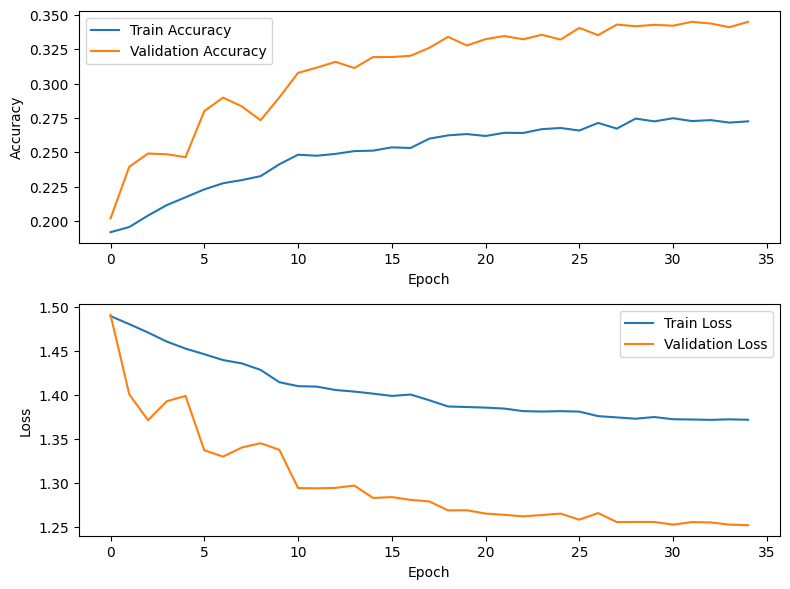

In [ ]:
criterion = AG.SoftHardTargetLoss(global_param.soft_citerion,global_param.hard_citerion, global_param.soft_purcntg, global_param.hard_purcntg)

optimizer_conv =  optim.SGD(winning_ticket.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler =  lr_scheduler.StepLR(optimizer_conv, step_size=9, gamma=0.5)

print("------------------------------ Training ---------------------------------")
# Train the model
winning_ticket, statics = AG.train_model_kd_mix(winning_ticket,model_base, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=35)
AG.show_statics_training(statics, save_to + 'winning_ticket')
torch.save(winning_ticket, save_to + 'winning_ticket')

In [ ]:
AG.evaluation_2(winning_ticket, nn.CrossEntropyLoss())

Accuracy: 34.49%
Loss: 2.5891


(0.3449, 2.5891337668060497)